In [36]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, GRU, Dense, Masking, Reshape, Flatten, RepeatVector, TimeDistributed, Bidirectional, Activation, GaussianNoise, Lambda, LSTM
from tensorflow.keras import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from Models.BioSigBandVAE_One import *
from Utilities.Utilities import *

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"


#### Env setting

In [37]:
SavePath = './Results/'
ModelName = 'SigBandRep_AllOnce_ExtRec.hdf5'

### Model related parameters
LatDim = 3
MaskingRate = 0.02
NoiseStd = 0.002
MaskStd = 0.1
ReparaStd = 0.1
Capacity_Z = 0.1
Capacity_Fc = 0.6
TrRate = 0.8

### Other parameters
Patience = 300
TrRate = 0.8

if not os.path.exists(SavePath):
    os.mkdir(SavePath)

### Model checkpoint
ModelSaveName = SavePath+ModelName

### Model Early stop
EarlyStop = EarlyStopping(monitor='val_loss', patience=Patience)

### Data

In [38]:
DATA = np.load('./Data/AsanTRSet.npy')
SigDim = DATA.shape[1]

np.random.seed(7)
PermutedDATA = np.random.permutation(DATA)
TrLen = int(PermutedDATA.shape[0] * TrRate)

TrData = PermutedDATA[:TrLen]
ValData = PermutedDATA[TrLen:]

### Model Definition

In [6]:
### Encoder - FeatExtractor
EncInp, EncOut = Encoder(SigDim=SigDim, LatDim= LatDim, Type = '', MaskingRate = MaskingRate, NoiseStd = NoiseStd, MaskStd = MaskStd, ReparaStd = ReparaStd, Reparam=True)
FeatExtOut = FeatExtractor(EncOut)

### Encoder - FeatGenerator - Reconstruction
FeatGenOut = FeatGenerator([EncOut[1],EncOut[2][:, :2], EncOut[2][:, 2:]])
FeatGenOut = ReName(FeatGenOut, 'FeatGenOut')

ReconOut = Reconstructor([FeatExtOut , EncOut[2]], SigDim = SigDim)
ReconOut = ReName(ReconOut, 'ReconOut')

### Define the total model
SigBandRepModel = Model(EncInp, ReconOut)

### Weight controller; Apply beta and capacity 
Capacity_Z = 0.1 # 0.1 0.05
Capacity_Fc = 0.6
Beta_Z = Lossweight(name='Beta_Z')(FeatGenOut)
Beta_Fc = Lossweight(name='Beta_Fc')(FeatGenOut)
Beta_Rec = Lossweight(name='Beta_Rec', InitVal=500.)(FeatGenOut)
Beta_Feat = Lossweight(name='Beta_Feat', InitVal=500.)(FeatGenOut)


### Adding the RecLoss; 
MSE = tf.keras.losses.MeanSquaredError()
RecLoss = Beta_Rec * MSE(ReconOut, EncInp)
SigBandRepModel.add_loss(RecLoss)
SigBandRepModel.add_metric(RecLoss, 'RecLoss')


### Adding the FeatRecLoss; It allows connection between the extractor and generator
FeatRecLoss= Beta_Feat * MSE(tf.concat(FeatGenOut, axis=-1), tf.concat(FeatExtOut, axis=-1))
SigBandRepModel.add_loss(FeatRecLoss)
SigBandRepModel.add_metric(FeatRecLoss, 'FeatRecLoss')

### KL Divergence for p(Z) vs q(Z)
Z_Sampled, Z_Log_Sigma = SigBandRepModel.get_layer('Z_Mean').output, SigBandRepModel.get_layer('Z_Log_Sigma').output
kl_Loss_Z = 0.5 * tf.reduce_sum( Z_Sampled**2  +  tf.exp(Z_Log_Sigma)- Z_Log_Sigma-1, axis=1)    
kl_Loss_Z = tf.reduce_mean(kl_Loss_Z )
kl_Loss_Z = Beta_Z * tf.abs(kl_Loss_Z - Capacity_Z)

### KL Divergence for p(FCs) vs q(FCs)
BernP = 0.5 # hyperparameter
FCs = SigBandRepModel.get_layer('FCs').output
kl_Loss_FC = tf.math.log(FCs) - tf.math.log(BernP) + tf.math.log(1-FCs) - tf.math.log(1-BernP) 
kl_Loss_FC = tf.reduce_mean(-kl_Loss_FC )
kl_Loss_FC = Beta_Fc * tf.abs(kl_Loss_FC - Capacity_Fc)

SigBandRepModel.add_loss(kl_Loss_Z )
SigBandRepModel.add_metric(kl_Loss_Z , 'kl_Loss_Z')

SigBandRepModel.add_loss(kl_Loss_FC )
SigBandRepModel.add_metric(kl_Loss_FC , 'kl_Loss_FC')

## Model Compile
SigBandRepModel.compile(optimizer='adam') 

### Loss and KLD_Beta controller
KLD_Beta_Z = KLAnneal(TargetLossName=['val_FeatRecLoss', 'val_RecLoss'], Threshold=0.001, BetaName='Beta_Z',  MaxBeta=0.1 , MinBeta=0.1, AnnealEpoch=1, UnderLimit=1e-7, verbose=2)
KLD_Beta_Fc = KLAnneal(TargetLossName=['val_FeatRecLoss', 'val_RecLoss'], Threshold=0.001, BetaName='Beta_Fc',  MaxBeta=0.005 , MinBeta=0.005, AnnealEpoch=1, UnderLimit=1e-7, verbose=1)

RelLossDic = {'val_RecLoss':'Beta_Rec', 'val_FeatRecLoss':'Beta_Feat', 'val_kl_Loss_Z':'Beta_Z', 'val_kl_Loss_FC':'Beta_Fc'}
ScalingDic = {'val_RecLoss':100., 'val_FeatRecLoss':100., 'val_kl_Loss_Z':0.1, 'val_kl_Loss_FC':0.1}
MinLimit = {'Beta_Rec':1., 'Beta_Feat':1., 'Beta_Z':0.01, 'Beta_Fc':0.01}
MaxLimit = {'Beta_Rec':500., 'Beta_Feat':500., 'Beta_Z':0.07, 'Beta_Fc':0.05}
RelLoss = RelLossWeight(BetaList=RelLossDic, LossScaling= ScalingDic, MinLimit= MinLimit, MaxLimit = MaxLimit, ToSaveLoss=['val_FeatRecLoss', 'val_RecLoss'] , SaveWay='max' , SavePath = ModelSaveName)

In [ ]:
SigBandRepModel.load_weights(ModelSaveName)
#ModelSave = ModelCheckpoint(filepath=ModelSaveName, monitor='val_FeatRecLoss', verbose=1, save_best_only=True )

SigBandRepModel.fit(TrData, batch_size=3500, epochs=1000, shuffle=True, validation_data =(ValData, None) , callbacks=[EarlyStop,  RelLoss]) # ModelSave,

### Post model

In [7]:
### Encoder - FeatExtractor
EncInp, EncOut = Encoder(SigDim=SigDim, LatDim= LatDim, Type = '', MaskingRate = MaskingRate, NoiseStd = NoiseStd, MaskStd = MaskStd, ReparaStd = ReparaStd, Reparam=False)
FeatExtOut = FeatExtractor(EncOut)

### Encoder - FeatGenerator - Reconstruction
FeatGenOut = FeatGenerator([EncOut[1],EncOut[2][:, :2], EncOut[2][:, 2:]])
FeatGenOut = ReName(FeatGenOut, 'FeatGenOut')

ReconOut = Reconstructor([FeatExtOut , EncOut[2]],SigDim=SigDim)
ReconOut = ReName(ReconOut, 'ReconOut')

### Define the total model
SigBandRepModel = Model(EncInp, ReconOut)

### Weight controller; Apply beta and capacity 
Capacity_Z = 0.1 # 0.1 0.05
Capacity_Fc = 0.6
Beta_Z = Lossweight(name='Beta_Z')(FeatGenOut)
Beta_Fc = Lossweight(name='Beta_Fc')(FeatGenOut)
Beta_Rec = Lossweight(name='Beta_Rec', InitVal=500.)(FeatGenOut)
Beta_Feat = Lossweight(name='Beta_Feat', InitVal=500.)(FeatGenOut)


### Adding the RecLoss; 
MSE = tf.keras.losses.MeanSquaredError()
RecLoss = Beta_Rec * MSE(ReconOut, EncInp)
SigBandRepModel.add_loss(RecLoss)
SigBandRepModel.add_metric(RecLoss, 'RecLoss')


### Adding the FeatRecLoss; It allows connection between the extractor and generator
FeatRecLoss= Beta_Feat * MSE(tf.concat(FeatGenOut, axis=-1), tf.concat(FeatExtOut, axis=-1))
SigBandRepModel.add_loss(FeatRecLoss)
SigBandRepModel.add_metric(FeatRecLoss, 'FeatRecLoss')

### KL Divergence for p(Z) vs q(Z)
Z_Sampled, Z_Log_Sigma = SigBandRepModel.get_layer('Z_Mean').output, SigBandRepModel.get_layer('Z_Log_Sigma').output
kl_Loss_Z = 0.5 * tf.reduce_sum( Z_Sampled**2  +  tf.exp(Z_Log_Sigma)- Z_Log_Sigma-1, axis=1)    
kl_Loss_Z = tf.reduce_mean(kl_Loss_Z )
kl_Loss_Z = Beta_Z * tf.abs(kl_Loss_Z - Capacity_Z)

### KL Divergence for p(FCs) vs q(FCs)
BernP = 0.5 # hyperparameter
FCs = SigBandRepModel.get_layer('FCs').output
kl_Loss_FC = tf.math.log(FCs) - tf.math.log(BernP) + tf.math.log(1-FCs) - tf.math.log(1-BernP) 
kl_Loss_FC = tf.reduce_mean(-kl_Loss_FC )
kl_Loss_FC = Beta_Fc * tf.abs(kl_Loss_FC - Capacity_Fc)

SigBandRepModel.add_loss(kl_Loss_Z )
SigBandRepModel.add_metric(kl_Loss_Z , 'kl_Loss_Z')

SigBandRepModel.add_loss(kl_Loss_FC )
SigBandRepModel.add_metric(kl_Loss_FC , 'kl_Loss_FC')

### Load weights
SigBandRepModel.load_weights(ModelSaveName)


### Regularizer resetting
for i in SigBandRepModel.weights:
    if i.name.split('/')[0] in ['Beta_Z','Beta_Fc','Beta_Rec','Beta_Feat']:
        i.assign(1.)


## Model Compile
SigBandRepModel.compile(optimizer='adam') 

#### Model evaluation

In [8]:
SigBandRepModel.evaluate(ValData,  batch_size=3500, verbose=1)

23/23 [==============================] - 69s 3s/step - loss: 0.7431 - RecLoss: 6.8383e-04 - FeatRecLoss: 3.5000e-04 - kl_Loss_Z: 0.3877 - kl_Loss_FC: 0.3531


[0.741763710975647,
 0.0006838308763690293,
 0.00035000304342247546,
 0.3876533806324005,
 0.3530765175819397]

In [9]:
def LayerExtractor(Backborn, Subtractor):
    
    SelectLayers = [i for i in Backborn if i not in Subtractor]
    
    SelectWeights = []
    for i in SelectLayers:
        SelectWeights.extend(i.get_weights())
    
    return SelectWeights



EncOut = [SigBandRepModel.get_layer('SigOut').output,
          SigBandRepModel.get_layer('Z_Mean').output,
          SigBandRepModel.get_layer('FCs').output ]


FeatExtOut = [SigBandRepModel.get_layer('Sig_HH_Ext').output,
              SigBandRepModel.get_layer('Sig_HL_Ext').output,
              SigBandRepModel.get_layer('Sig_LH_Ext').output,
              SigBandRepModel.get_layer('Sig_LL_Ext').output]

FeatGenOut = [SigBandRepModel.get_layer('Sig_HH_Gen').output,
              SigBandRepModel.get_layer('Sig_HL_Gen').output,
              SigBandRepModel.get_layer('Sig_LH_Gen').output,
              SigBandRepModel.get_layer('Sig_LL_Gen').output]

FCs = SigBandRepModel.get_layer('FCs').output

EncoderLayers = Model(SigBandRepModel.input, EncOut).layers
Enc2FeatExtLayers = Model(SigBandRepModel.input, FeatExtOut).layers
Enc2FeatGenLayers = Model(SigBandRepModel.input, FeatGenOut).layers
Enc2ReconLayers = Model(SigBandRepModel.input, SigBandRepModel.output).layers
len(EncoderLayers), len(Enc2FeatExtLayers), len(Enc2FeatGenLayers), len(Enc2ReconLayers), len(SigBandRepModel.layers)

(26, 121, 69, 136, 257)

In [12]:
### Feat Generator Reconstruction and Load Weights
Post_InpZ = Input((LatDim,))
Post_FCCommon = Input((2,))
Post_FCEach =Input((4,))
Post_FeatGenOut = FeatGenerator([Post_InpZ,Post_FCCommon,Post_FCEach])
Post_FeatGenModel = Model([Post_InpZ, Post_FCCommon, Post_FCEach], Post_FeatGenOut)

# Weight updating 
Pre_FeatGenWeights = LayerExtractor(Enc2FeatGenLayers, EncoderLayers)
Post_FeatGenModel.set_weights(Pre_FeatGenWeights)


### Reconstructor Reconstruction and Load Weights
Sig_HH_Gen = Input((400,))
Sig_HL_Gen = Input((400,))
Sig_LH_Gen = Input((400,))
Sig_LL_Gen = Input((400,))
FCs = Input((6,))
ReconOut =  Reconstructor([[Sig_HH_Gen, Sig_HL_Gen, Sig_LH_Gen, Sig_LL_Gen], FCs], SigDim=SigDim)
Post_ReconModel = Model([Sig_HH_Gen, Sig_HL_Gen, Sig_LH_Gen, Sig_LL_Gen, FCs], ReconOut)

# Weight updating 
Pre_ReconWeights = LayerExtractor(Enc2ReconLayers, Enc2FeatExtLayers)
Post_ReconModel.set_weights(Pre_ReconWeights)

### Incorporating two parts into one model
Post_ReconOut = Post_ReconModel([Post_FeatGenModel.output, FCs])
SigGenerator = Model([Post_FeatGenModel.input, FCs], Post_ReconOut)

In [31]:
N_Exp = 100
#Z_pred = np.tile(np.zeros(LatDim), (N_Exp,1))
Z_pred = np.linspace(-0.5, 0.5, N_Exp*LatDim).reshape(N_Exp, -1)

#FC_Comm = np.random.uniform(0,1, N_Exp * 2).reshape(N_Exp, -1)
#FC_Comm = np.linspace(0,1, N_Exp * 2).reshape(N_Exp, -1)
#FC_Comm = np.tile(np.ones(2) * 1., (N_Exp,1))
FC_Comm = np.tile(np.ones(2) * 0.5, (N_Exp,1))

#FC_Each = np.random.uniform(0,1, N_Exp * 4).reshape(N_Exp, -1)
#FC_Each = np.linspace(0,1, N_Exp * 4).reshape(N_Exp, -1)
#FC_Each = np.tile(np.ones(4) * 1.0, (N_Exp,1))
FC_Each = np.tile(np.ones(4) * 0.5, (N_Exp,1))

In [32]:
FeatGen = Post_FeatGenModel.predict([Z_pred,FC_Comm,FC_Each], batch_size=1000)
SigGen = SigGenerator.predict([Z_pred,FC_Comm,FC_Each, np.concatenate([FC_Comm,FC_Each], axis=-1)], batch_size=1000)

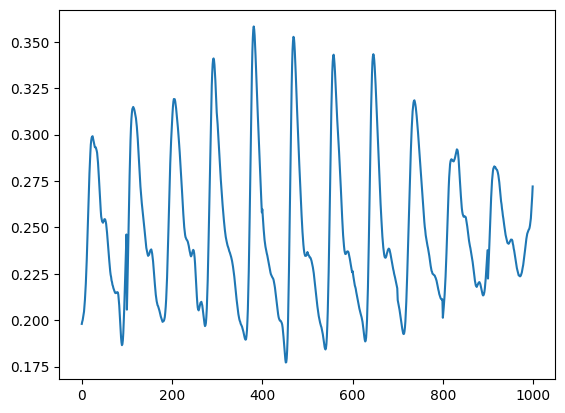

In [33]:
plt.plot(SigGen[4])

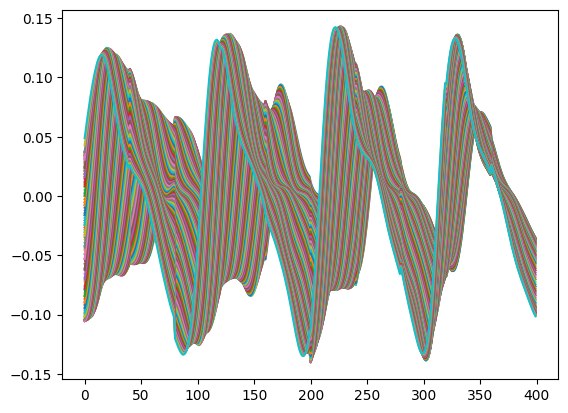

In [34]:
for i in range(N_Exp):
    plt.plot(FeatGen[0][i])

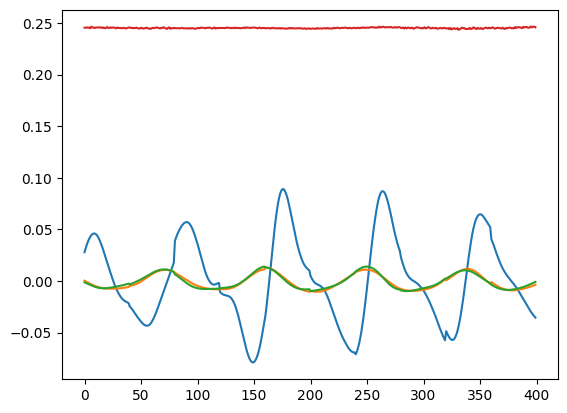

In [35]:
for i in range(4):
    plt.plot(FeatGen[i][5])